# Set up

## install

In [1]:
!nvidia-smi

Sat Feb  8 21:34:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:25:00.0 Off |                    0 |
| N/A   36C    P0             48W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Get total number of logical (including hyperthreading) CPU cores
logical_cores = os.cpu_count()
print(f"Logical CPU Cores: {logical_cores}")

# Get number of physical cores (without hyperthreading)
physical_cores = psutil.cpu_count(logical=False)
print(f"Physical CPU Cores: {physical_cores}")

In [ ]:
# Get system memory details
mem = psutil.virtual_memory()

# Total RAM
print(f"Total RAM: {mem.total / (1024**3):.2f} GB")

# Available RAM
print(f"Available RAM: {mem.available / (1024**3):.2f} GB")

# Used RAM
print(f"Used RAM: {mem.used / (1024**3):.2f} GB")

# RAM Usage Percentage
print(f"RAM Usage: {mem.percent}%")

In [ ]:
# Get CPU usage per core
cpu_usage_per_core = psutil.cpu_percent(percpu=True)
print(f"CPU Usage per core: {cpu_usage_per_core}")

# Get overall CPU usage
cpu_usage = psutil.cpu_percent()
print(f"Overall CPU Usage: {cpu_usage}%")

In [ ]:
#!pip install geopandas
#!pip install folium
#!pip install mapclassify
#!pip install streetview
#!pip install keplergl
#!pip install osmnx
#!pip install pygris

In [2]:
import os
import psutil
import math
import time
import yaml
import shutil
import zipfile
import random
import requests
import cv2
import itertools
import json
import copy
from IPython.display import display_html
from scipy.spatial import ConvexHull
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import folium
import matplotlib 
import mapclassify
import seaborn as sns

from collections import Counter
from streetview import search_panoramas, get_panorama_meta, get_streetview, get_panorama_async, get_panorama

In [3]:
from shapely.geometry import MultiLineString
from shapely.ops import linemerge, unary_union
from shapely.geometry import Point

In [4]:
import torch  # For PyTorch
print(torch.cuda.is_available())  # True means a GPU is accessible

import ultralytics
from ultralytics import YOLO
from ultralytics import settings
ultralytics.checks()

Ultralytics 8.3.66 🚀 Python-3.10.12 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-PCIE-40GB, 40446MiB)
Setup complete ✅ (64 CPUs, 503.2 GB RAM, 0.0/0.0 GB disk)


In [5]:
import subprocess

def install_opencv_headless():
    try:
        subprocess.run(["pip", "install", "opencv-python-headless"], check=True)
        print("opencv-python-headless installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

install_opencv_headless()

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
opencv-python-headless installed successfully.



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


## ultralytics settings

In [6]:
# refer to the following page
# https://docs.ultralytics.com/quickstart/#modifying-settings

In [7]:
!pwd

/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/code


In [8]:
base_dir = "/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc"
base_dir

'/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc'

In [9]:
#print(settings)

In [10]:
# refer to the following page
# https://docs.ultralytics.com/quickstart/#modifying-settings

# Update a setting+
settings.update({"datasets_dir": os.path.join(base_dir, "cvat_export")})
settings.update({"weights_dir": os.path.join(base_dir, "current_training/weights")})
settings.update({"runs_dir": os.path.join(base_dir, "current_training/runs")})
print(settings)

# Reset settings to default values
# settings.reset()

JSONDict("/home/hice1/jlee4338/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/cvat_export",
  "weights_dir": "/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/current_training/weights",
  "runs_dir": "/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/current_training/runs",
  "uuid": "03e9e516df57c4506ba2f666b65d3a494d7d5521dfb3553eec5e6c3ca7475924",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


# Inference on ATL GSV images

## prepare ATL images

In [35]:
base_dir = '../data_atl'
folder_path = os.path.join(base_dir, "img_middown_0208")    
print(folder_path)

filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg", ".png"))]
filenames = sorted(filenames)
filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg", ".png"))]
print(len(filenames))
filenames[:5]

../data_atl/img_middown_0208
7788


['../data_atl/img_middown_0208/gsv__215__12__right__139.361__2019-10__33.775806801,-84.379175182.jpg',
 '../data_atl/img_middown_0208/gsv__173__11__right__48.943__2022-03__33.785063793,-84.384255698.jpg',
 '../data_atl/img_middown_0208/gsv__530__3__left__78.461__2024-07__33.750691195,-84.393234343.jpg',
 '../data_atl/img_middown_0208/gsv__239__4__right__139.456__2024-11__33.796786698,-84.38753574.jpg',
 '../data_atl/img_middown_0208/gsv__405__9__right__168.371__2024-06__33.752104796,-84.395139153.jpg']

## load the model

In [36]:
#model_nc_1
#model_trained = YOLO('/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/current_training/runs/detect/model_nc_1/weights/best.pt')
#model_nc_5
model_trained = YOLO('/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/current_training/runs/detect/model_nc_5/weights/best.pt')
#model_nc_6
#model_trained = YOLO('/storage/ice1/2/4/jlee4338/ongoing/park_sign/nyc/current_training/runs/detect/model_nc_6/weights/best.pt')

In [37]:
results = model_trained.predict(filenames[0], conf=0.1, device="cuda:0", save=False, verbose=False)
for result in results:
    print(result)

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'prohibAnyT', 1: 'prohibSomeT', 2: 'prohibBusStop', 3: 'prohibClean', 4: 'allow'}
obb: None
orig_img: array([[[232, 233, 224],
        [242, 243, 234],
        [246, 244, 236],
        ...,
        [194, 173, 171],
        [162, 139, 137],
        [136, 113, 111]],

       [[225, 226, 217],
        [229, 230, 221],
        [231, 229, 221],
        ...,
        [144, 123, 121],
        [176, 155, 153],
        [211, 190, 188]],

       [[234, 232, 224],
        [237, 235, 227],
        [241, 238, 230],
        ...,
        [221, 201, 200],
        [237, 217, 216],
        [234, 214, 213]],

       ...,

       [[ 93,  74,  69],
        [ 82,  63,  58],
        [ 90,  71,  66],
        ...,
        [ 38,  36,  35],
        [ 25,  23,  22],
        [ 27,  25,  24]],

       [[ 96,  77,  72],
        [ 96,  77,  72],
        [102,  83,  78],
    

In [38]:
del results
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=memory.free --format=csv,nounits

memory.free [MiB]
39700


## apply the model 

In [39]:
output_folder = "inferred_model_nc_5"

In [40]:
# Function to create multiple ranges with increasing intervals
def generate_ranges(start, stop, interval, num_ranges):
    ranges = []
    for i in range(num_ranges):
        ranges.append(range(start + i * interval, start + (i + 1) * interval))
    return ranges

ranges = generate_ranges(0, 100, 100, 78)
print(ranges[0]) 
print(ranges[1]) 
print("...")
print(ranges[-2]) 
print(ranges[-1]) 

range(0, 100)
range(100, 200)
...
range(7600, 7700)
range(7700, 7800)


In [41]:
base_dir = '../data_atl'
output_path = os.path.join(base_dir, "inferred", output_folder)
print(output_path)
THRES_CONFID = 0.1
THRES_AREA = 400

../data_atl/inferred/inferred_model_nc_5


In [42]:
log_detected = []

command = ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits"]

os.makedirs(output_path, exist_ok=True)

for i, r in enumerate(ranges):
    print(f"{i}th range starts:{r}")
    batch_range = r
    files = filenames[batch_range[0]:batch_range[-1]]
    results = model_trained.predict(files, conf=THRES_CONFID, device="cuda:0", save=False, verbose=False, batch=2, half=True)

    for k, result in enumerate(results):
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        boxes = result.boxes.data
        file = files[k].split("/")[-1]
        file = file.split(".j")[0]
        file = "__".join([file.split("__")[1], file.split("__")[2], file.split("__")[3]])

        for j, box in enumerate(boxes):
            xmin, ymin, xmax, ymax, confidence, class_id = box.tolist()  # Convert tensor to list
            class_id = int(class_id)
            xmin, ymin, xmax, ymax, confidence = int(xmin), int(ymin), int(xmax), int(ymax), round(confidence, 2)  # Convert to integers
            area = (xmax-xmin) * (ymax-ymin)

            # Crop the ROI
            if confidence > THRES_CONFID and area > THRES_AREA:
                filename = f"{file}__{j}__{class_id}__{confidence}__{area}.jpg"
                result.save(filename= os.path.join(output_path, filename))  # save to disk
                
                log_detected.append({
                    "range_index": i,
                    "file_id": file,
                    "detection_index": j,
                    "class_id": class_id,
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                    "confidence": confidence,
                    "area": area,
                    "saved_filename": filename
                })

    # delete the results for the current range
    del results
    torch.cuda.empty_cache()

    # Command to query GPU free memory
    # Execute the command and capture the output
    shell_op = subprocess.run(command, stdout=subprocess.PIPE, text=True)

    # Print the output
    print(shell_op.stdout)

0th range starts:range(0, 100)
memory.free [MiB]
39700

1th range starts:range(100, 200)
memory.free [MiB]
39700

2th range starts:range(200, 300)
memory.free [MiB]
39700

3th range starts:range(300, 400)
memory.free [MiB]
39700

4th range starts:range(400, 500)
memory.free [MiB]
39700

5th range starts:range(500, 600)
memory.free [MiB]
39700

6th range starts:range(600, 700)
memory.free [MiB]
39700

7th range starts:range(700, 800)
memory.free [MiB]
39700

8th range starts:range(800, 900)
memory.free [MiB]
39700

9th range starts:range(900, 1000)
memory.free [MiB]
39700

10th range starts:range(1000, 1100)
memory.free [MiB]
39700

11th range starts:range(1100, 1200)
memory.free [MiB]
39700

12th range starts:range(1200, 1300)
memory.free [MiB]
39700

13th range starts:range(1300, 1400)
memory.free [MiB]
39700

14th range starts:range(1400, 1500)
memory.free [MiB]
39700

15th range starts:range(1500, 1600)
memory.free [MiB]
39700

16th range starts:range(1600, 1700)
memory.free [MiB]
3

## result

### log data

In [50]:
log_detected_df = pd.DataFrame(log_detected)
log_detected_df

range_index         file_id  detection_index  class_id  xmin  ymin  xmax  \
0              0  413__12__right                2         3   346   240   367   
1              0   503__13__left                0         0   579   326   610   
2              0    468__5__left                0         1   261   271   294   
3              0    390__9__left                0         3   103   316   124   
4              0     76__4__left                0         3    46   287    71   
..           ...             ...              ...       ...   ...   ...   ...   
401           77   93__16__right                0         2   320   292   340   
402           77    117__0__left                0         1   460   322   485   
403           77   208__20__left                0         4   326   227   351   
404           77    102__3__left                0         3   238   281   257   
405           77    258__8__left                0         0   219   231   297   

     ymax  confidence  area                       saved_filename  
0     274        0.11   714  413__12__right__2__3__0.11__714.jpg  
1     345        0.62   589   503__13__left__0__0__0.62__589.jpg  
2     320        0.17  1617   468__5__left__0__1__0.17__1617.jpg  
3     353        0.67   777    390__9__left__0__3__0.67__777.jpg  
4     311        0.24   600     76__4__left__0__3__0.24__600.jpg  
..    ...         ...   ...                                  ...  
401   320        0.24   560   93__16__right__0__2__0.24__560.jpg  
402   341        0.51   475    117__0__left__0__1__0.51__475.jpg  
403   259        0.22   800   208__20__left__0__4__0.22__800.jpg  
404   303        0.47   418    102__3__left__0__3__0.47__418.jpg  
405   298        0.28  5226   258__8__left__0__0__0.28__5226.jpg  

[406 rows x 11 columns]

In [51]:
base_dir

'../data_atl'

In [52]:
log_detected_df.to_csv(os.path.join(base_dir, "inferred", "log_detected_df.csv"))

In [53]:
log_detected_df.groupby("file_id")["file_id"].count()

file_id
100__15__right    1
100__17__right    1
101__0__right     1
102__3__left      1
103__8__left      1
                 ..
93__16__right     1
94__10__left      1
94__17__right     1
94__2__right      2
97__3__left       1
Name: file_id, Length: 357, dtype: int64

In [54]:
log_detected_df.groupby("class_id")["class_id"].count()

class_id
0     56
1     52
2    109
3    141
4     48
Name: class_id, dtype: int64

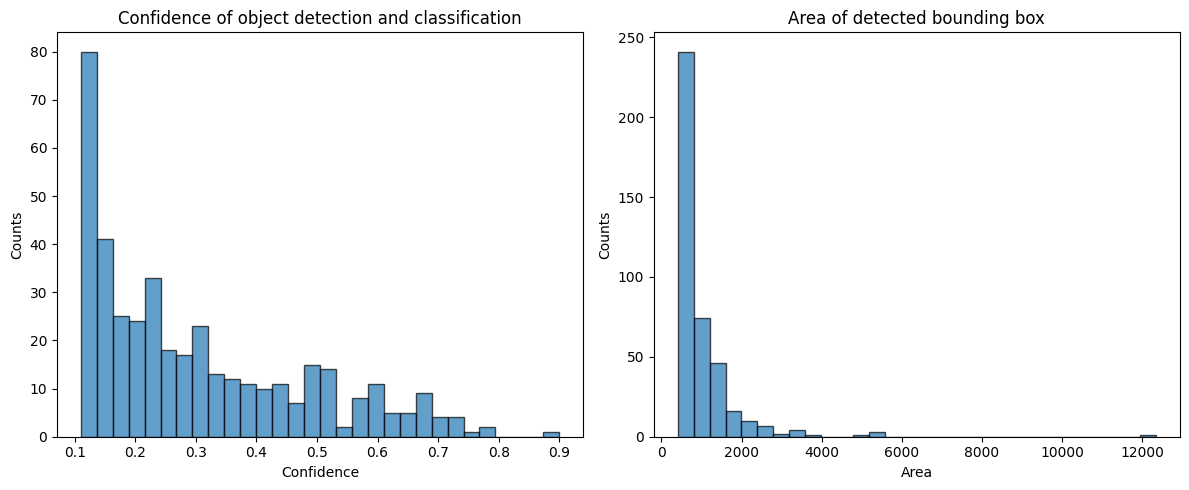

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(log_detected_df["confidence"], bins=30, edgecolor='black', alpha=0.7)
ax1.set_xlabel("Confidence")
ax1.set_ylabel("Counts")
ax1.set_title("Confidence of object detection and classification")

ax2.hist(log_detected_df["area"], bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel("Area")
ax2.set_ylabel("Counts")
ax2.set_title("Area of detected bounding box")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

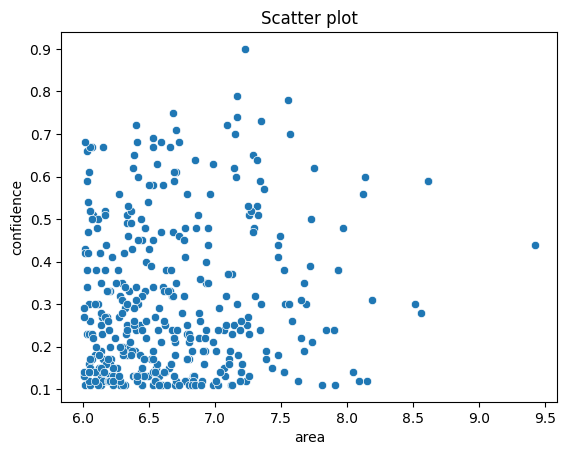

In [163]:
sns.scatterplot(x=np.log(log_detected_df["area"]), y=log_detected_df["confidence"])

# Add labels and title
plt.xlabel('area')
plt.ylabel('confidence')
plt.title('Scatter plot')

# Show the plot
plt.show()

### mapping

In [181]:
base_dir = '../data_atl'
folder_path = os.path.join(base_dir, "inferred", "inferred_model_nc_5")
print(folder_path)
print()
filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg", ".png"))]
filenames = sorted(filenames)
filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg", ".png"))]
print(len(filenames))
filenames_detected = filenames
del filenames
filenames_detected[:5]

../../data_atl/inferred/inferred_model_nc_5

406


['../../data_atl/inferred/inferred_model_nc_5/403__6__right__0__0.16__480.jpg',
 '../../data_atl/inferred/inferred_model_nc_5/526__5__left__0__0.51__561.jpg',
 '../../data_atl/inferred/inferred_model_nc_5/273__12__left__1__0.14__472.jpg',
 '../../data_atl/inferred/inferred_model_nc_5/286__17__left__0__0.35__816.jpg',
 '../../data_atl/inferred/inferred_model_nc_5/325__6__left__0__0.62__1260.jpg']

In [182]:
filenames_detected = [f.split("/")[-1] for f in filenames_detected]
filenames_detected[:5]

['403__6__right__0__0.16__480.jpg',
 '526__5__left__0__0.51__561.jpg',
 '273__12__left__1__0.14__472.jpg',
 '286__17__left__0__0.35__816.jpg',
 '325__6__left__0__0.62__1260.jpg']

In [183]:
# side 1 and 2 should be differentiated later on by using ([f.split("_")[0], f.split("_")[2], f.split("_")[1]])
filenames_detected = ["__".join([f.split("__")[0], f.split("__")[1], f.split("__")[2]]) for f in filenames_detected]
filenames_detected[:5]

['403__6__right',
 '526__5__left',
 '273__12__left',
 '286__17__left',
 '325__6__left']

In [184]:
atl_edges_points_pano_cleaned_azi_long

edge_id  point_id   osm_id    road_type oneway        lat        lng  \
0          1         0  9234648  residential    yes  33.765351 -84.397162   
1          1         2  9234648  residential    yes  33.765351 -84.397072   
2          1         5  9234648  residential    yes  33.765350 -84.396937   
3          1         7  9234648  residential    yes  33.765349 -84.396847   
4          1        10  9234648  residential    yes  33.765348 -84.396713   
...      ...       ...      ...          ...    ...        ...        ...   
7783      99        10  9268354  residential     no  33.778555 -84.384973   
7784      99        13  9268354  residential     no  33.778564 -84.385107   
7785      99        15  9268354  residential     no  33.778571 -84.385197   
7786      99        18  9268354  residential     no  33.778581 -84.385331   
7787      99        20  9268354  residential     no  33.778587 -84.385420   

                     pano_id  \
0     PbiPOcHuu3n1nKBBvofmvg   
1     _PQ_bzr5OlU039L-LIquaw   
2     IY3jwST4ju8V_Ol7qFsPIQ   
3     5FK_yaBXm3O0EEOE-Qae_Q   
4     pwGEtsxRkzxTeCWcCTaUug   
...                      ...   
7783  GZD7MUi2IHmHy7T_6Il7UQ   
7784  08oNtvAILG5sLqdGvoXwZA   
7785  fxmGQS21JY_JwnviOokUXA   
7786  AWvYU4fXX_cvCNhEsXHxtQ   
7787  IWgF46B_sPY8YJsjad73Vw   

                                          pano_location   pano_lat   pano_lng  \
0     { "lat": 33.765354455587733, "lng": -84.397169...  33.765354 -84.397170   
1     { "lat": 33.765352957076168, "lng": -84.397050...  33.765353 -84.397050   
2     { "lat": 33.765351617799787, "lng": -84.396940...  33.765352 -84.396940   
3     { "lat": 33.76535033378412, "lng": -84.3968350...  33.765350 -84.396835   
4     { "lat": 33.765349025616914, "lng": -84.396727...  33.765349 -84.396727   
...                                                 ...        ...        ...   
7783  { "lat": 33.778560633140927, "lng": -84.384992...  33.778561 -84.384993   
7784  { "lat": 33.778568190141812, "lng": -84.385099...  33.778568 -84.385099   
7785  { "lat": 33.778576546952657, "lng": -84.385208...  33.778577 -84.385208   
7786  { "lat": 33.778585273948487, "lng": -84.385321...  33.778585 -84.385322   
7787  { "lat": 33.778593935256382, "lng": -84.385434...  33.778594 -84.385434   

         date  euc_dist                    geometry     azimuth azimuth_side  \
0     2023-01  0.810233  POINT (-84.39717 33.76535)   90.865648        right   
1     2023-01  2.002906  POINT (-84.39705 33.76535)   90.837856        right   
2     2023-01  0.346549  POINT (-84.39694 33.76535)   90.841245        right   
3     2023-01  1.141240  POINT (-84.39684 33.76535)   90.837907        right   
4     2023-01  1.380561  POINT (-84.39673 33.76535)   90.851763        right   
...       ...       ...                         ...         ...          ...   
7783  2024-07  1.960252  POINT (-84.38499 33.77856)  274.879933         left   
7784  2024-07  0.841701   POINT (-84.3851 33.77857)  275.263486         left   
7785  2024-07  1.265274  POINT (-84.38521 33.77858)  275.283045         left   
7786  2024-07  0.960103  POINT (-84.38532 33.77859)  275.310642         left   
7787  2024-07  1.471796  POINT (-84.38543 33.77859)  275.332589         left   

      azimuth_toget     unique_id  
0        135.865648   1__0__right  
1        135.837856   1__2__right  
2        135.841245   1__5__right  
3        135.837907   1__7__right  
4        135.851763  1__10__right  
...             ...           ...  
7783     139.879933  99__10__left  
7784     140.263486  99__13__left  
7785     140.283045  99__15__left  
7786     140.310642  99__18__left  
7787            NaN  99__20__left  

[7788 rows x 18 columns]

In [180]:
atl_edges_points_pano_cleaned_azi_long["unique_id"] = atl_edges_points_pano_cleaned_azi_long[
    ["edge_id", "point_id", "azimuth_side"]
].astype(str).agg("__".join, axis=1)
atl_edges_points_pano_cleaned_azi_long[0:5]

edge_id  point_id   osm_id    road_type oneway        lat        lng  \
0       1         0  9234648  residential    yes  33.765351 -84.397162   
1       1         2  9234648  residential    yes  33.765351 -84.397072   
2       1         5  9234648  residential    yes  33.765350 -84.396937   
3       1         7  9234648  residential    yes  33.765349 -84.396847   
4       1        10  9234648  residential    yes  33.765348 -84.396713   

                  pano_id                                      pano_location  \
0  PbiPOcHuu3n1nKBBvofmvg  { "lat": 33.765354455587733, "lng": -84.397169...   
1  _PQ_bzr5OlU039L-LIquaw  { "lat": 33.765352957076168, "lng": -84.397050...   
2  IY3jwST4ju8V_Ol7qFsPIQ  { "lat": 33.765351617799787, "lng": -84.396940...   
3  5FK_yaBXm3O0EEOE-Qae_Q  { "lat": 33.76535033378412, "lng": -84.3968350...   
4  pwGEtsxRkzxTeCWcCTaUug  { "lat": 33.765349025616914, "lng": -84.396727...   

    pano_lat   pano_lng     date  euc_dist                    geometry  \
0  33.765354 -84.397170  2023-01  0.810233  POINT (-84.39717 33.76535)   
1  33.765353 -84.397050  2023-01  2.002906  POINT (-84.39705 33.76535)   
2  33.765352 -84.396940  2023-01  0.346549  POINT (-84.39694 33.76535)   
3  33.765350 -84.396835  2023-01  1.141240  POINT (-84.39684 33.76535)   
4  33.765349 -84.396727  2023-01  1.380561  POINT (-84.39673 33.76535)   

     azimuth azimuth_side  azimuth_toget     unique_id  
0  90.865648        right     135.865648   1__0__right  
1  90.837856        right     135.837856   1__2__right  
2  90.841245        right     135.841245   1__5__right  
3  90.837907        right     135.837907   1__7__right  
4  90.851763        right     135.851763  1__10__right

In [206]:
atl_edges_points_pano_cleaned_azi_long_detected = atl_edges_points_pano_cleaned_azi_long[atl_edges_points_pano_cleaned_azi_long["unique_id"].isin(filenames_detected)]
atl_edges_points_pano_cleaned_azi_long_detected

edge_id  point_id   osm_id    road_type oneway        lat        lng  \
19       100        15  9268354  residential     no  33.778686 -84.386646   
20       100        17  9268354  residential     no  33.778693 -84.386736   
23       101         0  9268358  residential     no  33.778314 -84.375043   
78       109         0  9269231  residential     no  33.775332 -84.377458   
100      111         1  9269357  residential    yes  33.755314 -84.379430   
...      ...       ...      ...          ...    ...        ...        ...   
7719      91        15  9268186  residential     no  33.776923 -84.375265   
7721      91        20  9268186  residential     no  33.777109 -84.375262   
7725      91        29  9268186  residential     no  33.777445 -84.375257   
7748      94        10  9268187  residential     no  33.774822 -84.375873   
7767      97         3  9268354  residential     no  33.778350 -84.381568   

                     pano_id  \
19    b__vjV9YHo6GTyueaSplbQ   
20    e3hu8yUM9hq5c2hRUmhV0A   
23    6YerQPh5wPBC5arjgz9JMA   
78    ZStokg-MzVnQ2fzURBdQng   
100   gyNHXnLDHm7u27t2RiFCIw   
...                      ...   
7719  mx3HHaAzPAkKWAKp3_hlDA   
7721  SPU_n0m--F11xl5lX5_MRg   
7725  B7sLEOQDhz6QqIS6a-8nlg   
7748  k_-zLFKQLbH8XhelA0ypYA   
7767  ka0fPsINMuHvBhBaUzIf8w   

                                          pano_location   pano_lat   pano_lng  \
19    { "lat": 33.778700264161621, "lng": -84.386663...  33.778700 -84.386664   
20    { "lat": 33.778697073904752, "lng": -84.386718...  33.778697 -84.386719   
23    { "lat": 33.778323806625181, "lng": -84.375046...  33.778324 -84.375047   
78    { "lat": 33.775332305498459, "lng": -84.377498...  33.775332 -84.377498   
100   { "lat": 33.75530159960244, "lng": -84.3794314...  33.755302 -84.379431   
...                                                 ...        ...        ...   
7719  { "lat": 33.776910826086933, "lng": -84.375269...  33.776911 -84.375269   
7721  { "lat": 33.777093123787047, "lng": -84.375268...  33.777093 -84.375268   
7725  { "lat": 33.77745901115599, "lng": -84.3752601...  33.777459 -84.375260   
7748  { "lat": 33.77483346909812, "lng": -84.3758771...  33.774833 -84.375877   
7767  { "lat": 33.778351287436237, "lng": -84.381562...  33.778351 -84.381562   

         date  euc_dist                    geometry     azimuth azimuth_side  \
19    2024-07  2.246396   POINT (-84.38666 33.7787)  266.014429        right   
20    2024-07  1.653532   POINT (-84.38672 33.7787)  274.703515        right   
23    2022-02  1.106491  POINT (-84.37505 33.77832)   56.282068        right   
78    2023-01  3.729011   POINT (-84.3775 33.77533)   90.201561        right   
100   2024-07  1.348814   POINT (-84.37943 33.7553)  181.815531        right   
...       ...       ...                         ...         ...          ...   
7719  2024-07  1.370796  POINT (-84.37527 33.77691)    0.041436         left   
7721  2024-07  1.902466  POINT (-84.37527 33.77709)    2.129956         left   
7725  2024-07  1.553761  POINT (-84.37526 33.77746)    0.167462         left   
7748  2022-02  1.362684  POINT (-84.37588 33.77483)  356.507918         left   
7767  2023-01  0.489688  POINT (-84.38156 33.77835)  273.742169         left   

      azimuth_toget       unique_id  
19       311.014429  100__15__right  
20       319.703515  100__17__right  
23       101.282068   101__0__right  
78       135.201561   109__0__right  
100      226.815531   111__1__right  
...             ...             ...  
7719    -134.958564    91__15__left  
7721    -132.870044    91__20__left  
7725    -134.832538    91__29__left  
7748     221.507918    94__10__left  
7767     138.742169     97__3__left  

[357 rows x 18 columns]

In [207]:
m = atl_towns.explore(
    color="grey",  
    style_kwds={"fill": True, "weight": 1, "fillOpacity":0.8},
    tooltip=False,
    alpha=0.9
)

m = atl_edges_points_pano_cleaned_azi_long.groupby(["edge_id", "point_id"]).first().explore(
    m=m,
    color="black",  
    alpha=0.5,
    marker_kwds={"radius":0.01, "fillOpacity":0.5}
)

atl_edges_points_pano_cleaned_azi_long_detected.explore(
    m=m,
    color="red",  
    alpha=0.5,
    marker_kwds={"radius":3, "fillOpacity":0.9}
)

m

## use this for the final output

In [212]:
atl_edges_points_pano_cleaned_azi_long_detected_wide = atl_edges_points_pano_cleaned_azi_long_detected.pivot(index=["edge_id", "point_id"], columns="azimuth_side", values="azimuth_toget")
atl_edges_points_pano_cleaned_azi_long_detected_wide

azimuth_side            left       right
edge_id point_id                        
100     15               NaN  311.014429
        17               NaN  319.703515
101     0                NaN  101.282068
102     3         -45.135221         NaN
103     8         -40.347766         NaN
...                      ...         ...
93      16               NaN   45.918845
94      2                NaN  400.640775
        10        221.507918         NaN
        17               NaN  403.747478
97      3         138.742169         NaN

[328 rows x 2 columns]

In [213]:
atl_edges_points_pano_cleaned_azi_long_detected_wide["LR_detected"] = atl_edges_points_pano_cleaned_azi_long_detected_wide.apply(
    lambda row: "side_both" if pd.notna(row["left"]) and pd.notna(row["right"])   
    else "side_one",
    axis=1
)

In [215]:
atl_edges_points_pano_cleaned_azi_long_detected_wide

azimuth_side            left       right LR_detected
edge_id point_id                                    
100     15               NaN  311.014429    side_one
        17               NaN  319.703515    side_one
101     0                NaN  101.282068    side_one
102     3         -45.135221         NaN    side_one
103     8         -40.347766         NaN    side_one
...                      ...         ...         ...
93      16               NaN   45.918845    side_one
94      2                NaN  400.640775    side_one
        10        221.507918         NaN    side_one
        17               NaN  403.747478    side_one
97      3         138.742169         NaN    side_one

[328 rows x 3 columns]

In [219]:
atl_edges_points_pano_cleaned_azi_long_detected_wide.groupby("LR_detected")["LR_detected"].count()

LR_detected
side_both     10
side_one     318
Name: LR_detected, dtype: int64

In [222]:
atl_edges_points_pano_cleaned_azi_long_detected

edge_id  point_id   osm_id    road_type oneway        lat        lng  \
19       100        15  9268354  residential     no  33.778686 -84.386646   
20       100        17  9268354  residential     no  33.778693 -84.386736   
23       101         0  9268358  residential     no  33.778314 -84.375043   
78       109         0  9269231  residential     no  33.775332 -84.377458   
100      111         1  9269357  residential    yes  33.755314 -84.379430   
...      ...       ...      ...          ...    ...        ...        ...   
7719      91        15  9268186  residential     no  33.776923 -84.375265   
7721      91        20  9268186  residential     no  33.777109 -84.375262   
7725      91        29  9268186  residential     no  33.777445 -84.375257   
7748      94        10  9268187  residential     no  33.774822 -84.375873   
7767      97         3  9268354  residential     no  33.778350 -84.381568   

                     pano_id  \
19    b__vjV9YHo6GTyueaSplbQ   
20    e3hu8yUM9hq5c2hRUmhV0A   
23    6YerQPh5wPBC5arjgz9JMA   
78    ZStokg-MzVnQ2fzURBdQng   
100   gyNHXnLDHm7u27t2RiFCIw   
...                      ...   
7719  mx3HHaAzPAkKWAKp3_hlDA   
7721  SPU_n0m--F11xl5lX5_MRg   
7725  B7sLEOQDhz6QqIS6a-8nlg   
7748  k_-zLFKQLbH8XhelA0ypYA   
7767  ka0fPsINMuHvBhBaUzIf8w   

                                          pano_location   pano_lat   pano_lng  \
19    { "lat": 33.778700264161621, "lng": -84.386663...  33.778700 -84.386664   
20    { "lat": 33.778697073904752, "lng": -84.386718...  33.778697 -84.386719   
23    { "lat": 33.778323806625181, "lng": -84.375046...  33.778324 -84.375047   
78    { "lat": 33.775332305498459, "lng": -84.377498...  33.775332 -84.377498   
100   { "lat": 33.75530159960244, "lng": -84.3794314...  33.755302 -84.379431   
...                                                 ...        ...        ...   
7719  { "lat": 33.776910826086933, "lng": -84.375269...  33.776911 -84.375269   
7721  { "lat": 33.777093123787047, "lng": -84.375268...  33.777093 -84.375268   
7725  { "lat": 33.77745901115599, "lng": -84.3752601...  33.777459 -84.375260   
7748  { "lat": 33.77483346909812, "lng": -84.3758771...  33.774833 -84.375877   
7767  { "lat": 33.778351287436237, "lng": -84.381562...  33.778351 -84.381562   

         date  euc_dist                    geometry     azimuth azimuth_side  \
19    2024-07  2.246396   POINT (-84.38666 33.7787)  266.014429        right   
20    2024-07  1.653532   POINT (-84.38672 33.7787)  274.703515        right   
23    2022-02  1.106491  POINT (-84.37505 33.77832)   56.282068        right   
78    2023-01  3.729011   POINT (-84.3775 33.77533)   90.201561        right   
100   2024-07  1.348814   POINT (-84.37943 33.7553)  181.815531        right   
...       ...       ...                         ...         ...          ...   
7719  2024-07  1.370796  POINT (-84.37527 33.77691)    0.041436         left   
7721  2024-07  1.902466  POINT (-84.37527 33.77709)    2.129956         left   
7725  2024-07  1.553761  POINT (-84.37526 33.77746)    0.167462         left   
7748  2022-02  1.362684  POINT (-84.37588 33.77483)  356.507918         left   
7767  2023-01  0.489688  POINT (-84.38156 33.77835)  273.742169         left   

      azimuth_toget       unique_id  
19       311.014429  100__15__right  
20       319.703515  100__17__right  
23       101.282068   101__0__right  
78       135.201561   109__0__right  
100      226.815531   111__1__right  
...             ...             ...  
7719    -134.958564    91__15__left  
7721    -132.870044    91__20__left  
7725    -134.832538    91__29__left  
7748     221.507918    94__10__left  
7767     138.742169     97__3__left  

[357 rows x 18 columns]

In [223]:
atl_edges_points_pano_cleaned_azi_long_detected = atl_edges_points_pano_cleaned_azi_long_detected.merge(
    atl_edges_points_pano_cleaned_azi_long_detected_wide,
    on=["edge_id", "point_id"], how="left")
atl_edges_points_pano_cleaned_azi_long_detected

edge_id  point_id   osm_id    road_type oneway        lat        lng  \
0       100        15  9268354  residential     no  33.778686 -84.386646   
1       100        17  9268354  residential     no  33.778693 -84.386736   
2       101         0  9268358  residential     no  33.778314 -84.375043   
3       109         0  9269231  residential     no  33.775332 -84.377458   
4       111         1  9269357  residential    yes  33.755314 -84.379430   
..      ...       ...      ...          ...    ...        ...        ...   
352      91        15  9268186  residential     no  33.776923 -84.375265   
353      91        20  9268186  residential     no  33.777109 -84.375262   
354      91        29  9268186  residential     no  33.777445 -84.375257   
355      94        10  9268187  residential     no  33.774822 -84.375873   
356      97         3  9268354  residential     no  33.778350 -84.381568   

                    pano_id  \
0    b__vjV9YHo6GTyueaSplbQ   
1    e3hu8yUM9hq5c2hRUmhV0A   
2    6YerQPh5wPBC5arjgz9JMA   
3    ZStokg-MzVnQ2fzURBdQng   
4    gyNHXnLDHm7u27t2RiFCIw   
..                      ...   
352  mx3HHaAzPAkKWAKp3_hlDA   
353  SPU_n0m--F11xl5lX5_MRg   
354  B7sLEOQDhz6QqIS6a-8nlg   
355  k_-zLFKQLbH8XhelA0ypYA   
356  ka0fPsINMuHvBhBaUzIf8w   

                                         pano_location   pano_lat  ...  \
0    { "lat": 33.778700264161621, "lng": -84.386663...  33.778700  ...   
1    { "lat": 33.778697073904752, "lng": -84.386718...  33.778697  ...   
2    { "lat": 33.778323806625181, "lng": -84.375046...  33.778324  ...   
3    { "lat": 33.775332305498459, "lng": -84.377498...  33.775332  ...   
4    { "lat": 33.75530159960244, "lng": -84.3794314...  33.755302  ...   
..                                                 ...        ...  ...   
352  { "lat": 33.776910826086933, "lng": -84.375269...  33.776911  ...   
353  { "lat": 33.777093123787047, "lng": -84.375268...  33.777093  ...   
354  { "lat": 33.77745901115599, "lng": -84.3752601...  33.777459  ...   
355  { "lat": 33.77483346909812, "lng": -84.3758771...  33.774833  ...   
356  { "lat": 33.778351287436237, "lng": -84.381562...  33.778351  ...   

        date  euc_dist                    geometry     azimuth  azimuth_side  \
0    2024-07  2.246396   POINT (-84.38666 33.7787)  266.014429         right   
1    2024-07  1.653532   POINT (-84.38672 33.7787)  274.703515         right   
2    2022-02  1.106491  POINT (-84.37505 33.77832)   56.282068         right   
3    2023-01  3.729011   POINT (-84.3775 33.77533)   90.201561         right   
4    2024-07  1.348814   POINT (-84.37943 33.7553)  181.815531         right   
..       ...       ...                         ...         ...           ...   
352  2024-07  1.370796  POINT (-84.37527 33.77691)    0.041436          left   
353  2024-07  1.902466  POINT (-84.37527 33.77709)    2.129956          left   
354  2024-07  1.553761  POINT (-84.37526 33.77746)    0.167462          left   
355  2022-02  1.362684  POINT (-84.37588 33.77483)  356.507918          left   
356  2023-01  0.489688  POINT (-84.38156 33.77835)  273.742169          left   

    azimuth_toget       unique_id        left       right  LR_detected  
0      311.014429  100__15__right         NaN  311.014429     side_one  
1      319.703515  100__17__right         NaN  319.703515     side_one  
2      101.282068   101__0__right         NaN  101.282068     side_one  
3      135.201561   109__0__right  -44.798439  135.201561    side_both  
4      226.815531   111__1__right         NaN  226.815531     side_one  
..            ...             ...         ...         ...          ...  
352   -134.958564    91__15__left -134.958564         NaN     side_one  
353   -132.870044    91__20__left -132.870044         NaN     side_one  
354   -134.832538    91__29__left -134.832538         NaN     side_one  
355    221.507918    94__10__left  221.507918         NaN     side_one  
356    138.742169     97__3__left  138.742169         NaN     sid

In [229]:
m = atl_towns.explore(
    color="grey",  
    style_kwds={"fill": True, "weight": 1, "fillOpacity":0.8},
    tooltip=False,
    alpha=0.9
)

m = atl_edges_points_pano_cleaned_azi_long.groupby(["edge_id", "point_id"]).first().explore(
    m=m,
    color="black",  
    alpha=0.01,
    marker_kwds={"radius":0.001, "fillOpacity":0.01}
)

strong_palette = ["#D70000", "#0047AB"]

atl_edges_points_pano_cleaned_azi_long_detected.explore(
    m=m,
    column="LR_detected",  
    alpha=1,
    cmap=strong_palette,
    marker_kwds={"radius":3, "fillOpacity":1}
)

m

/tmp/ipykernel_1095410/442988814.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("coolwarm_r"),  # Alternative strong color map


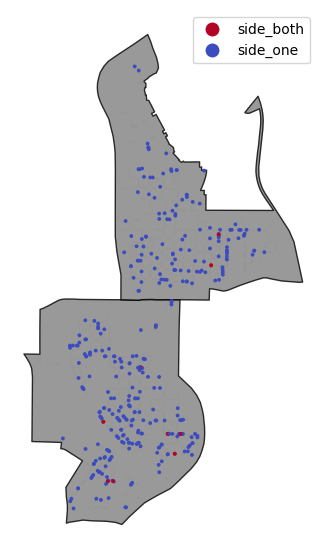

In [231]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot atl_towns with grey fill and slightly transparent
atl_towns.plot(ax=ax, color="grey", edgecolor="black", alpha=0.8)

# Plot atl_edges_points_pano_cleaned_azi_long as small black points
atl_edges_points_pano_cleaned_azi_long.groupby(["edge_id", "point_id"]).first().plot(
    ax=ax, color="black", markersize=0.1, alpha=0.01
)

# Define strong red & blue palette for left/right detection
#strong_palette = {"left": "#D70000", "right": "#0047AB"}

# Plot detected points using strong colors
atl_edges_points_pano_cleaned_azi_long_detected.plot(
    ax=ax,
    column="LR_detected",
    markersize=3,
    alpha=1,
    cmap=plt.cm.get_cmap("coolwarm_r"),  # Alternative strong color map
    legend=True
)

# Remove axis for better visualization
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show the plot
plt.show()